### Implementation of [SIRR Using Deep Encoder-Decoder Network](https://arxiv.org/abs/1802.00094)

[Review of the paper](https://github.com/topilskiyak/glare/blob/master/research/latex/research.pdf)

## TODone

~1 Improve performance of dataset generation~  
~ Implemented dataset generation using [kornia](https://kornia.readthedocs.io/en/latest/) on GPU (-2s)  
~ ImageFolder: switched from default loader=PIL to loader=cv2.imread  (-0.2s)  
Currently: ~0.85s per batch=[64,3,128,128]  
(raw imagefolder->img2tensor->float->(gpu)resize is ~0.75s/b)  
NUM_DATALOADER_WORKERS=0 (CUDA forbids fork used as default for dataloader)  
TODO:  
~ time-profile further  
~ map image-folder into tmpfs (RAM) (or load all images into RAM)  
~ pregenerate the whole dataset, save it and during training only load  
~ use fixed gaussian kernel size instead of auto-determining it  
~ use [spawn](https://pytorch.org/docs/stable/notes/multiprocessing.html#multiprocessing-best-practices) for multiple workers in [dataloader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)  
~ change [torchvision backend](https://pytorch.org/docs/stable/torchvision/index.html#torchvision.get_image_backend) to [accimage](https://github.com/pytorch/accimage)



## TODO

2 Double reflections  
3 find_lr (into cyclic\_lr?) @fastai, etc  
4 vgg-loss  


Ideas  
~ negative sampling of bad restorations


In [1]:
# https://kornia.readthedocs.io/en/latest/
!pip install kornia

In [1]:
# Imports
import os
from functools import partial
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

from torchsummary import summary

import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

import kornia

# Global Variables
DEBUG = False
DOWNLOAD_DATASETS = False

DEVICE = 'cuda'
NUM_DATALOADER_WORKERS = 0

MAX_EPOCHS = 100
BATCH_SIZE = 64
LEARNING_RATE = 1e-3

## Helpers

In [2]:
def imshow(img):
  plt.imshow(img)
  plt.show()

## Dataset

In [3]:
if DOWNLOAD_DATASETS:
  !wget http://groups.csail.mit.edu/vision/LabelMe/NewImages/indoorCVPR_09.tar -O indoorCVPR_09.tar
  !tar -C . -xf indoorCVPR_09.tar
  !mv Images indoorCVPR_09
!ls indoorCVPR_09

airport_inside	computerroom	     inside_subway   pantry
artstudio	concert_hall	     jewelleryshop   poolinside
auditorium	corridor	     kindergarden    prisoncell
bakery		deli		     kitchen	     restaurant
bar		dentaloffice	     laboratorywet   restaurant_kitchen
bathroom	dining_room	     laundromat      shoeshop
bedroom		elevator	     library	     stairscase
bookstore	fastfood_restaurant  livingroom      studiomusic
bowling		florist		     lobby	     subway
buffet		gameroom	     locker_room     toystore
casino		garage		     mall	     trainstation
children_room	greenhouse	     meeting_room    tv_studio
church_inside	grocerystore	     movietheater    videostore
classroom	gym		     museum	     waitingroom
cloister	hairsalon	     nursery	     warehouse
closet		hospitalroom	     office	     winecellar
clothingstore	inside_bus	     operating_room


In [4]:
def cv2loader(path):
  img_bgr = cv2.imread(path)
  if img_bgr is not None:
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    return img_rgb
  img = torchvision.datasets.folder.pil_loader(path)
  return np.array(img)

images = ImageFolder('indoorCVPR_09', loader=cv2loader)

if DEBUG:
  for i in tqdm(range(min(2000, len(images)))):
    _ = images[i][0]
  print(f'len={len(images)}')
  print(f'element={[type(p) for p in images[0]]}, dtype={images[0][0].dtype}')
  print(f'shapes={[images[i][0].shape for i in np.random.randint(0, len(images), 3)]}')
  print(f'max={images[0][0].max():.2f}, mean={images[0][0].mean():.2f}, min={images[0][0].min():.2f}')
  imshow(images[len(images) // 2][0])

In [5]:
def preprocess_image_to_tensor(img):
  t = kornia.image_to_tensor(img, keepdim=False).to(DEVICE)
  t = t.float() / 255
  return t

def apply_real_image_constraints(t):
  return torch.clamp(t, 0, 1)

def restore_tensor_to_image(t):
  t = t.detach()
  t = (apply_real_image_constraints(t) * 255).byte().cpu()
  img = kornia.tensor_to_image(t)
  return img


def imshow_tensor(t):
  img = restore_tensor_to_image(t)
  imshow(img)


if DEBUG:
  imshow_tensor(preprocess_image_to_tensor(images[0][0]))

In [6]:
def get_gaussian_kernel2D(sigma, truncate=2.0):
  # https://github.com/scipy/scipy/blob/v1.5.3/scipy/ndimage/filters.py#L212
  size = int(truncate * sigma + 0.5)
  size += 1 - size % 2  # size must be odd
  kernel = kornia.filters.kernels.get_gaussian_kernel2d((size, size), (sigma, sigma))
  kernel = torch.unsqueeze(kernel, dim=0)
  return kernel.to(DEVICE)

In [7]:
class SIRRDataset(Dataset):
  class Settings:
    def __init__(self, alpha=(0.75, 0.8), sigma=(1, 5), size=(128, 128)):
      self.balpha = alpha[0]
      self.dalpha = alpha[1] - alpha[0]
      self.bsigma = sigma[0]
      self.dsigma = sigma[1] - sigma[0]
      self.size = size

  def __init__(self, images, part=1.0, settings=Settings()):
    self.images = images
    self.len = int(len(images) * part)
    self.settings = settings
  
  def __len__(self):
    return self.len
  
  def __getitem__(self, index):
    T_img, _ = self.images[index]
    R_img, _ = self.images[np.random.randint(0, self.len)]
    alpha = self.settings.balpha + np.random.rand() * self.settings.dalpha
    sigma = self.settings.bsigma + np.random.rand() * self.settings.dsigma

    T_full = preprocess_image_to_tensor(T_img)
    T_resized = kornia.geometry.transform.resize(T_full, size=self.settings.size)
    T_unsqueezed = apply_real_image_constraints(T_resized)
    T = torch.squeeze(T_unsqueezed, dim=0)
    alpha_T = alpha * T

    R_full = preprocess_image_to_tensor(R_img)
    gauss_kernel = get_gaussian_kernel2D(sigma)
    R_full_blurred = kornia.filters.filter2D(R_full, kernel=gauss_kernel)
    R_resized = kornia.geometry.transform.resize(R_full_blurred, size=self.settings.size)
    R_unsqueezed = apply_real_image_constraints(R_resized)
    R = torch.squeeze(R_unsqueezed, dim=0)

    I_raw = alpha_T + (1 - alpha) * R
    I = apply_real_image_constraints(I_raw)

    return {
        "image": I,
        "alpha_transmission": alpha_T,
        "alpha": alpha,
    }

dataset_train = SIRRDataset(images)
dataset_test = SIRRDataset(images, part=0.1)

if DEBUG:
  print(f'train={len(dataset_train)}')
  print(f'test={len(dataset_test)}')
  example = dataset_train[len(dataset_train) // 2]

  image = example["image"]
  alpha_T = example["alpha_transmission"]
  alpha = example["alpha"]

  assert image.size() == alpha_T.size()
  imshow_tensor(image)
  imshow_tensor(alpha_T / alpha)
  imshow_tensor((image - alpha_T) / (1 - alpha))

In [8]:
NUM_DATALOADER_WORKERS = 0
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_DATALOADER_WORKERS)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_DATALOADER_WORKERS)

if DEBUG:
  assert len(dataloader_train) == (len(dataset_train) + BATCH_SIZE - 1) // BATCH_SIZE
  assert len(dataloader_test) == (len(dataset_test) + BATCH_SIZE - 1) // BATCH_SIZE
  
  batch = None
  for batch in tqdm(dataloader_test):
    assert len(batch["image"].size()) == 4
    assert len(batch["alpha_transmission"].size()) == 4
    assert len(batch["alpha"].size()) == 1
    assert batch["image"].size()[0] <= BATCH_SIZE

  image = batch["image"][0]
  alpha_T = batch["alpha_transmission"][0]
  alpha = batch["alpha"][0]

  assert image.size() == alpha_T.size()
  imshow_tensor(image)
  imshow_tensor(alpha_T / alpha)
  imshow_tensor((image - alpha_T) / (1 - alpha))


## Architecture

In [9]:
class FeatureExtractionCNN(nn.Module):
  def __init__(self, in_, filters):
    super(FeatureExtractionCNN, self).__init__()
    self.cnn = nn.Sequential(
      nn.Conv2d(in_, filters, kernel_size=9, padding=0),
      nn.ReLU(),
      nn.Conv2d(filters, filters, kernel_size=9, padding=0),
      nn.ReLU(),
      nn.Conv2d(filters, filters, kernel_size=5, padding=0),
      nn.ReLU(),
      nn.Conv2d(filters, filters, kernel_size=5, padding=0),
      nn.ReLU(),
      nn.Conv2d(filters, filters, kernel_size=5, padding=0),
      nn.ReLU(),
      nn.Conv2d(filters, filters, kernel_size=5, padding=0),
      #nn.ReLU(),  # skip-connection add/sub works with features before ReLU
    )
  
  def forward(self, x):
    return self.cnn(x)


class RRUNetDownBlock(nn.Module):
  def __init__(self, filters):
    super(RRUNetDownBlock, self).__init__()
    self.cnn = nn.Sequential(
      nn.ReLU(),
      nn.Conv2d(filters, filters, kernel_size=5, padding=0),
      nn.ReLU(),
      nn.Conv2d(filters, filters, kernel_size=5, padding=0),
    )
  def forward(self, x):
    return self.cnn(x)

class RRUNetUpBlock(nn.Module):
  def __init__(self, filters):
    super(RRUNetUpBlock, self).__init__()
    self.cnn = nn.Sequential(
      nn.ReLU(),
      nn.ConvTranspose2d(filters, filters, kernel_size=5, padding=0),
      nn.ReLU(),
      nn.ConvTranspose2d(filters, filters, kernel_size=5, padding=0),
    )
  def forward(self, x):
    return self.cnn(x)

class ReflectionRemovalUNet(nn.Module):
  def __init__(self, filters, depth):
    super(ReflectionRemovalUNet, self).__init__()
    self.down = nn.ModuleList([RRUNetDownBlock(filters) for _ in range(depth)])
    self.up = nn.ModuleList([RRUNetUpBlock(filters) for _ in range(depth)])
    assert len(self.down) == len(self.up)
  
  def forward(self, x):
    reflection = x

    down_features = []
    for down in self.down[:-1]:
      reflection = down(reflection)
      down_features.append(reflection)

    reflection = self.down[-1](reflection)
    reflection = self.up[0](reflection)

    for up, skip_features in zip(self.up[1:], reversed(down_features)):
      reflection += skip_features
      reflection = up(reflection)

    return F.relu(x - reflection)


class TransmissionRestorationCNN(nn.Module):
  def __init__(self, filters, out):
    super(TransmissionRestorationCNN, self).__init__()
    self.cnn = nn.Sequential(
      nn.ConvTranspose2d(filters, filters, kernel_size=5, padding=0),
      nn.ReLU(),
      nn.ConvTranspose2d(filters, filters, kernel_size=5, padding=0),
      nn.ReLU(),
      nn.ConvTranspose2d(filters, filters, kernel_size=5, padding=0),
      nn.ReLU(),
      nn.ConvTranspose2d(filters, filters, kernel_size=5, padding=0),
      nn.ReLU(),
      nn.ConvTranspose2d(filters, filters, kernel_size=9, padding=0),
      nn.ReLU(),
      nn.ConvTranspose2d(filters, out, kernel_size=9, padding=0),
      nn.ReLU(),  # TODO: skip last relu, since clip01 afterwards anyway?
    )
  
  def forward(self, x):
    return self.cnn(x)


class SIRRNet(nn.Module):
  def __init__(self, in_, filters, depth):
    super(SIRRNet, self).__init__()
    self.feature_extraction = FeatureExtractionCNN(in_, filters)
    self.reflection_removal = ReflectionRemovalUNet(filters, depth)
    self.transmission_restoration = TransmissionRestorationCNN(filters, in_)
  
  def forward(self, x):
    features = self.feature_extraction(x)
    features_reflection_removed = self.reflection_removal(features)
    restored = self.transmission_restoration(features_reflection_removed)
    return restored

model = SIRRNet(in_=3, filters=64, depth=3).to(DEVICE)

if True:
  summary(model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]          15,616
              ReLU-2           [-1, 64, 56, 56]               0
            Conv2d-3           [-1, 64, 48, 48]         331,840
              ReLU-4           [-1, 64, 48, 48]               0
            Conv2d-5           [-1, 64, 44, 44]         102,464
              ReLU-6           [-1, 64, 44, 44]               0
            Conv2d-7           [-1, 64, 40, 40]         102,464
              ReLU-8           [-1, 64, 40, 40]               0
            Conv2d-9           [-1, 64, 36, 36]         102,464
             ReLU-10           [-1, 64, 36, 36]               0
           Conv2d-11           [-1, 64, 32, 32]         102,464
FeatureExtractionCNN-12           [-1, 64, 32, 32]               0
             ReLU-13           [-1, 64, 32, 32]               0
           Conv2d-14           [-1, 

## Loss Function

In [10]:
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Training

In [13]:
def train_epoch(model, loader, criterion, optimizer):
  model.train()

  losses = []
  pbar = tqdm(loader)
  for batch in pbar:
    image = batch["image"]
    alpha_T = batch["alpha_transmission"]

    pred = model(image)
    loss = criterion(alpha_T, pred)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    losses.append(loss.item())
    pbar.set_description(
      "TR: "
      f"loss={np.mean(losses[-10:]):.5f}, "
      f"psnr={- 10 * np.log10(np.mean(losses)):.1f}")
  
  return losses

def evaluate(model, loader, criterion):
  def _evaluate():
    model.eval()

    losses = []
    pbar = tqdm(loader)
    for batch in pbar:
      image = batch["image"]
      alpha_T = batch["alpha_transmission"]

      pred = model(image)
      loss = criterion(alpha_T, pred)

      losses.append(loss.item())
      pbar.set_description(
        "TE: "
        f"loss={np.mean(losses):.5f}, "
        f"psnr={- 10 * np.log10(np.mean(losses)):.1f}")

  with torch.no_grad():
    return _evaluate()

def train(model, dataloader_train, dataloader_test, criterion, optimizer, 
          max_epochs):
  running_statistics = {
      "train": {"loss": []},
      "test":  {"loss": []}
  }

  for epoch in tqdm(range(max_epochs)):
    print(f"epoch={epoch:03d}")
    losses = train_epoch(model, dataloader_train, criterion, optimizer)
    test_loss = evaluate(model, dataloader_test, criterion)

    running_statistics["train"]["loss"].append(losses)
    running_statistics["test"]["loss"].append(test_loss)

    #TODO: early stopping using val_loss

  print("Finished training.")
  return running_statistics


In [14]:
_ = train(model, dataloader_train, dataloader_test, criterion, optimizer, MAX_EPOCHS)

epoch=000



epoch=001



epoch=002



epoch=003



epoch=004


KeyboardInterrupt: ignored

## Evaluation

In [33]:
def imshow_model(example, model):
  image = example["image"]
  alpha_T = example["alpha_transmission"]
  alpha = example["alpha"]

  pred = model(torch.unsqueeze(image, dim=0))
  pred = torch.squeeze(image, dim=0)


  print("image")
  imshow_tensor(image)
  print("model")
  imshow_tensor(pred)
  print("transmission")
  imshow_tensor(alpha_T)
  print("reflection")
  imshow_tensor((image - alpha_T) / (1 - alpha))

image


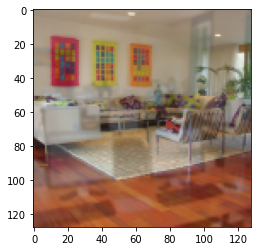

model


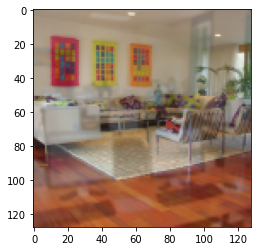

transmission


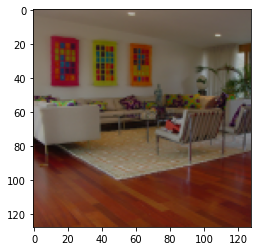

reflection


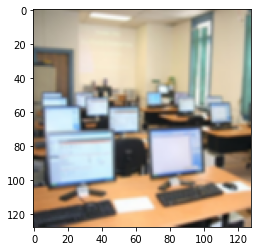

In [39]:
example = dataset_train[10000]
imshow_model(example, model)